In [7]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random
import logomaker

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/viz_utils.py'>

# allele specific pattern

In [17]:
cm = prepare_run_column(pd.read_csv(
    'data/hla_sign_clone_matrix/hla_covid_clonotype_matrix_500k_top_1_mismatch_hla_DRB1*16.csv').drop(
    columns=['Unnamed: 0'])).merge(prepare_run_column(
    pd.read_csv('data/desc_fmba_not_nan_hla.csv')[['run', 'COVID_status', 'folder']]))
cm = cm[cm.COVID_status != 'unknown'].dropna().replace({'precovid': 'healthy'})

In [18]:
cm_clones = cm[[x for x in cm.columns if x.startswith('CASS')]]
cm['sum_clones'] = cm_clones.sum(axis=1)

In [20]:
desc = cm[['run', 'COVID_status', 'sum_clones', 'folder']]
desc['covid'] = desc['COVID_status']

In [21]:
cm

,CASSRTGTGSSYNSPLHF,CASSRTGGGSSYNSPLHF,CASSRTGQGSSYNSPLHF,CASSRTGIGSSYNSPLHF,CASSRTGLGSSYNSPLHF,CASSRTGRGSSYNSPLHF,CASSRTGVGSSYNSPLHF,CASSRTGTRSSYNSPLHF,CASSRTGWGSSYNSPLHF,CASSRTGAGSSYNSPLHF,CASSRTGFGSSYNSPLHF,CASSRTGMGSSYNSPLHF,CASSRTGSGSSYNSPLHF,run,COVID_status,folder,sum_clones
0,0,0,0,0,0,0,0,0,0,0,0,0,0,020000010808_S3_L001,COVID,2020/10_FMBA_NovaSeq5,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,020003890808_S67_L001,COVID,2020/10_FMBA_NovaSeq5,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,020000700808_S134_L002,healthy,2020/10_FMBA_NovaSeq5,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,020000360808_S102_L002,healthy,2020/10_FMBA_NovaSeq5,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,050002090808_S74_L001,COVID,2020/10_FMBA_NovaSeq5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,0,0,0,0,0,0,0,0,0,0,0,640001930808_S53_L001,healthy,2020/10_FMBA_NovaSeq4,0
952,0,0,0,0,0,0,0,0,0,0,0,0,0,640002070808_S176_L002,healthy,2020/10_FMBA_NovaSeq4,0
953,0,0,0,0,0,0,0,0,0,0,0,0,0,210001800808_S136_L002,healthy,2020/10_FMBA_NovaSeq4,0
954,0,0,0,0,0,0,0,0,0,0,0,0,0,640003490808_S58_L001,healthy,2020/10_FMBA_NovaSeq4,0


Text(0.5, 1.0, 'Log usage of allele specific TCRβ biomarkers')

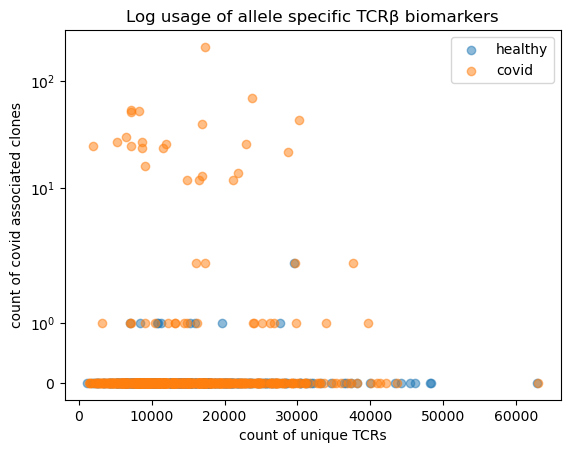

In [22]:
fig, ax = plt.subplots()
significant_clones_distribution(significant_clonotype_matrix=cm.drop(columns=['COVID_status','sum_clones', 'folder']), 
                                run_to_number_of_clones=prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv')), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                fit_reg=False,
                                reg_ax=ax)
ax.set_yscale('symlog')
ax.legend()
ax.set_title('Log usage of allele specific TCRβ biomarkers')

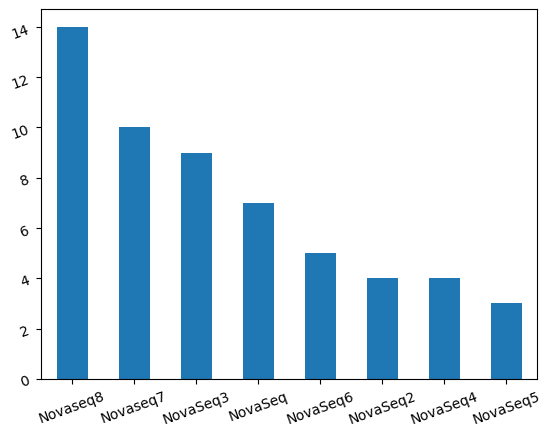

In [23]:
fig, ax = plt.subplots()
cm['short'] = cm.folder.apply(lambda x: x.split('_')[2])
cm[cm.sum_clones > 0].short.value_counts().plot(kind='bar', ax=ax)
ax.tick_params(labelrotation=20)


In [25]:
cm_with_clones = cm[cm.sum_clones > 0]

In [26]:
mat_df = logomaker.alignment_to_matrix(list(cm_clones.columns))

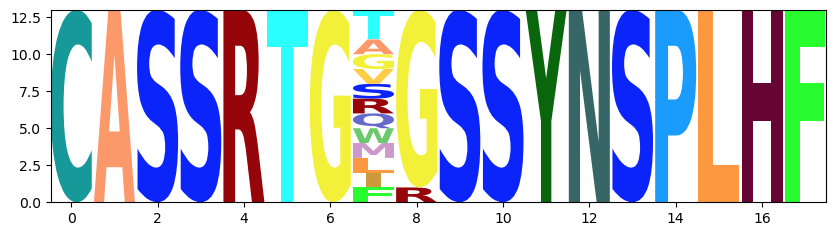

In [27]:
logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=None)

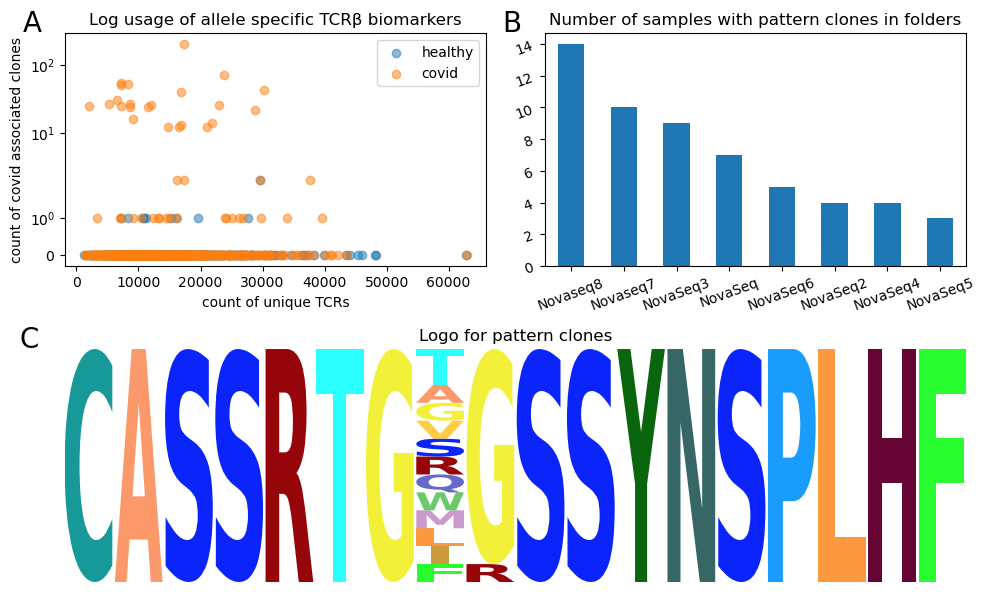

In [29]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(nrows=2, ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

significant_clones_distribution(significant_clonotype_matrix=cm.drop(columns=['COVID_status', 'sum_clones', 'folder']), 
                                run_to_number_of_clones=prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv')), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                fit_reg=False,
                                reg_ax=ax0)
ax0.set_yscale('symlog')
ax0.legend()
ax0.set_title('Log usage of allele specific TCRβ biomarkers')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)


cm[cm.sum_clones > 0].short.value_counts().plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=20)
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
ax1.set_title('Number of samples with pattern clones in folders')

####################################################

logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=ax2)
ax2.text(delta_x+0.05, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
ax2.set_title('Logo for pattern clones')
ax2.axis('off')
###################################################
plt.tight_layout()
plt.savefig("figures/fig3.svg")
plt.savefig("figures/fig3.pdf")
plt.savefig("figures/fig3.png")
plt.show()

Figure 3. Analysis of DRB1\*16, DQB1\*05 and COVID-19 associated TCRβ biomarkers.

A. The distribution of the number of pattern biomarkers compared between healthy and COVID-19 cohorts.

B. The number of samples containing pattern biomarkers in each batch of FMBA data.

C. The weblogo describing the pattern of DRB1*16, DQB1*05 and COVID-19 associated TCRβ biomarkers.